In [41]:
# Load sentence retrieval result
model_name = ["contriever", "multilingual-e5-large", "bge-large-en-v1.5", "gte-base"][0]
dataset_name = ["nfcorpus", "trec-covid", "nq-train"][2]
import json 
with open(f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2-d2d-retrieval.jsonl") as f:
    result = [json.loads(i) for i in f.readlines()]

In [42]:
# Load csv file for recall, precision, and f1
import pandas as pd
path = f"/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/retrieval/results/{model_name}/{dataset_name}-n-query-mt-2.csv"
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")

In [43]:
# Get grad norm dict
n_aug = 16
selection = ("min", "mean")[1] 
pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/gradnorm/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_gradnorms(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            l = l.replace('\'', '"')
            item = json.loads(l)
            gradnorms.append(float(item["grad_norm"]))
            '''
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
            '''
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    ids_selected = []
    func = lambda x: min(x) if selection == "min" else sum(x) / len(x)
    for i in range(0, len(ids)-1, n_aug):
        gradnorms_selected.append(func(gradnorms[i:i+n_aug]))
        ids_selected.append(ids[i])
    gradnorm_dict = {cid: gradnorm for cid, gradnorm in zip(ids_selected[:1270], gradnorms_selected[:1270])}
            
    return gradnorm_dict

gradnorm_dict = get_gradnorms(pth + f"{model_name}/{dataset_name}-result-0.02-temp-0.05") #-temp-0.02")

## Calculate nq-train threshold

In [44]:
sum(gradnorm_dict.values()) / len(gradnorm_dict.values())

# me5: 24.53
# contriever: 16.08
# bge-large: 18.02 / 
# gte: 16.57 / 16.23

16.084409986132663

In [55]:
# Load result
scores = []
recalls = []
#precisions = []
gradnorms = []
#f1s = []

for i in result:
        cid = i["_id"]
        if cid not in gradnorm_dict or cid not in df.index:
            continue
        #if df.loc[cid]["n-query"] < 5:
        #    continue
        succ = sum(map(lambda x: cid in x, i["retrieval"][:100]))
        count = len(i["retrieval"])
        if count < 3:
            continue
        score = round(succ / count * 100, 2)
        if df.loc[cid]["recall"] < 0.01: 
            continue
        gradnorms.append(gradnorm_dict[cid])
        scores.append(score)
        recalls.append(df.loc[cid]["recall"])
        #precisions.append(df.loc[cid]["precision"])
        #f1s.append(df.loc[cid]["f1"])

print(len(recalls), len(gradnorms))
print("Mean:", sum(gradnorms) / len(gradnorms))

72 72
Mean: 16.232726218752255


91 91
0.710356693072774


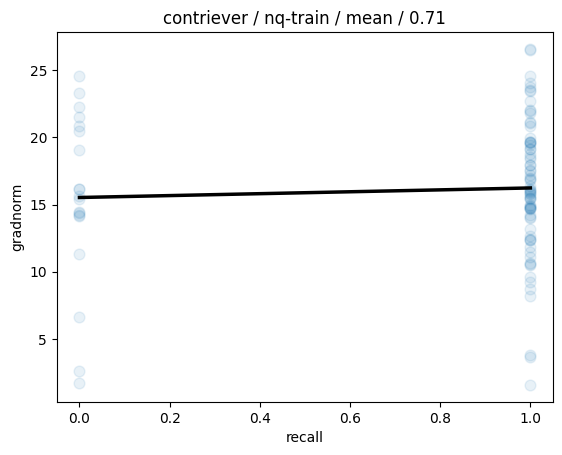

In [52]:
import matplotlib.pyplot as plt 

# Generate data
x = recalls
y = gradnorms

print(len(x), len(y))

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(x, y, s=60, alpha=0.1)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
import numpy as np
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 1, num=100)

# Plot regression line
plt.xlabel("recall")
plt.ylabel("gradnorm")
plt.title(f"{model_name} / {dataset_name} / {selection} / {round(b, 2)}")
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

print(b)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


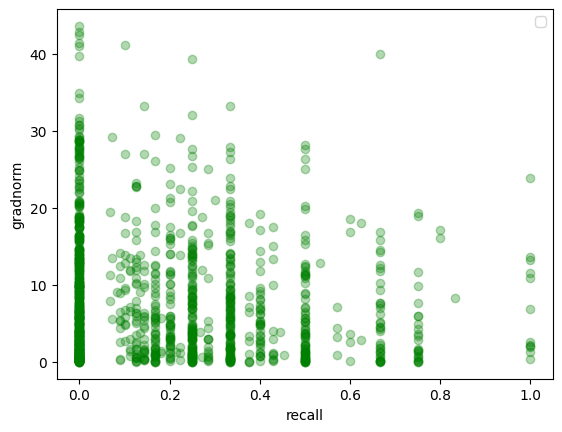

In [56]:
# Compare recall to gradnorm

plt.figure()
plt.xlabel("recall")
plt.ylabel("gradnorm")

plt.scatter(recalls, gradnorms, marker="o", color="green", alpha=0.3)
plt.legend()
 

### Load grad norm and plot mean 

In [57]:
pth = "/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_recall_and_score_list(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
        except:
            continue
    recalls = []
    for l in lines:
        try: 
            sid = l.index("recall: ") + len("recall: ") 
            eid = sid + 5
            recalls.append(int(float(l[sid:eid].strip()) * 100))
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    recalls_selected = []
    ids_selected = []
    func = min #lambda x: sum(x) / len(x)
    for i in range(0, len(ids), 4):
        gradnorms_selected.append(func(gradnorms[i:i+4]))
        recalls_selected.append(func(recalls[i:i+4]))
        ids_selected.append(ids[i])
            
    return recalls_selected, gradnorms_selected, ids_selected



ood_all = pth + "ood_all_update"
recalls, gradnorms, ids = get_recall_and_score_list(ood_all)
print(len(recalls), len(gradnorms), len(ids))

import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(recalls, gradnorms, color="green")
plt.xlabel("recall")
plt.ylabel("gradient norm")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

means = {k: [] for k in set(recalls)}
for r, g in zip(recalls, gradnorms):
    means[r].append(g)
means = {k: sum(v) / len(v) for k, v in means.items()}
means = sorted(list(means.items()), key= lambda x: int(x[0]))
xs = [i[0] for i in means]
ys = [i[1] for i in means]
plt.scatter(xs, ys, marker="x", color="red")
plt.legend()
 

FileNotFoundError: [Errno 2] No such file or directory: '/gallery_louvre/dayoon.ko/research/sds/eval_retrieval/BGE_M3/ood_all_update'